# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


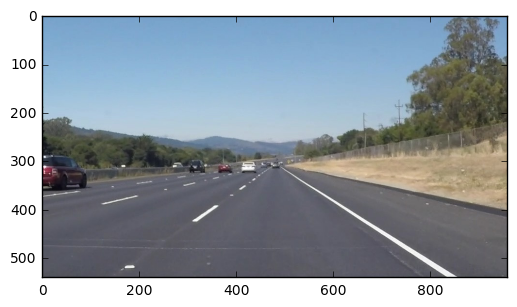

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    """ Applies an image mask. Keeps the region of the image defined by the 
    polygon formed from `vertices`. The rest of the image is set to black."""
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    """ Outputs and image with lines drawn on"""
    # Create Blank Image To Draw On
    line_img = np.copy(img)*0
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    #Initialize variables for left lane line
    left_x =[]
    left_y =[]
    left_slope = []
    left_b = []
    left_x_min = 0
    left_x_max = 0

    #Initialize variables for right lane line
    right_x =[]
    right_y = []
    right_slope = []
    right_b = []
    right_y_min = 0
    right_y_max = 0

    #Cycle through all hough lines, classify between left and right lane lines, and find points for best fit lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            #Determine if the coordinates belong in the right or left lane
            if slope < 0:
                left_x.extend([x1, x2])
                left_y.extend([y1, y2])
                left_slope.extend([slope])
                b = (np.mean(left_y))-(np.mean(slope)*np.mean(left_x))
                left_b.extend([b])
            if slope > 0:
                right_x.extend([x1,x2])
                right_y.extend([y1,y2])
                right_slope.extend([slope])
                b = (np.mean(right_y))-(np.mean(slope)*np.mean(right_x))
                right_b.extend([b])
    
    #Find max and mins for x values
    left_x_min= ((550-np.mean(left_b)) / (np.mean(left_slope)))
    left_x_max= ((330-np.mean(left_b)) / (np.mean(left_slope)))
    right_x_min= ((550-np.mean(right_b))/ (np.mean(right_slope)))
    right_x_max= ((330-np.mean(right_b))/ (np.mean(right_slope)))
    
    #Draw lines on the blank image
    line_img = cv2.line(line_img,(int(left_x_min) ,550), (int(left_x_max), 330), color, thickness)
    line_img = cv2.line(line_img,(int(right_x_min) ,550), (int(right_x_max), 330), color, thickness)
    return line_img


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """Returns an image with hough lines drawn."""
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, color=[255, 0, 0], thickness=15)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """ Combines two images based on assigned weights"""
    return cv2.addWeighted(initial_img, α, img, β, λ)


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

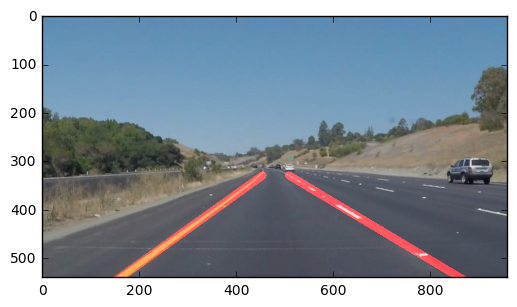

In [5]:
'''Read in the image'''
#image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#image = mpimg.imread('test_images/solidWhiteRight.jpg')
image = mpimg.imread('test_images/solidYellowCurve.jpg')
#image = mpimg.imread('test_images/solidYellowCurve2.jpg')
#image = mpimg.imread('test_images/solidYellowLeft.jpg')
#image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

# Create copy of original image
copy_image= np.copy(image)

# Grayscale the image
gray = grayscale(image)

# Apply Gaussian smoothing
blur_gray = gaussian_blur(gray, 3)

# Apply Canny Edge Detection
edges = canny(blur_gray, 180, 220)
#i did 40,170 before and it worked okay

# Next we'll create a masked edges image
vertices = np.array([[(120,image.shape[0]),(390, 330),(600, 330), (920,image.shape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)


# Define the Hough transform parameters
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50 #minimum number of pixels making up a line
max_line_gap = 40    # maximum gap in pixels between connectable line segments

# Apply Draw_lines() Function
line_img = np.copy(image)*0
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
test_lines = draw_lines(line_img, lines, color=[255, 0, 0], thickness=15)

# Combine original image with lines image
final_image = cv2.addWeighted(copy_image, .9, test_lines, 3, 0)

#Print final image
plt.imshow(final_image)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # Create copy of original image
    copy_image= np.copy(image)
    line_img = np.copy(image)*0
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

    # Grayscale the image
    gray = grayscale(image)

    # Apply Gaussian smoothing
    blur_gray = gaussian_blur(gray, 3)

    # Apply Canny Edge Detection
    edges = canny(blur_gray, 200, 270)
    #i did 40,170 before and it worked okay

    # Next we'll create a masked edges image using cv2.fillPoly()
    vertices = np.array([[(120,image.shape[0]),(390, 330),(600, 330), (920,image.shape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 # minimum number of pixels making up a line
    max_line_gap = 40    # maximum gap in pixels between connectable line segments

    # Apply the draw_lines() function
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    test_lines = draw_lines(line_img, lines, color=[255, 0, 0], thickness=15)

    # Combine two images using the weighted_image() function
    final_image = weighted_img(copy_image, test_lines, α=3, β=.9, λ=0)
    
    #Return final image
    return final_image

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'whiteFinal_17.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video whiteFinal_17.mp4
[MoviePy] Writing video whiteFinal_17.mp4


100%|█████████▉| 221/222 [00:06<00:00, 31.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: whiteFinal_17.mp4 

CPU times: user 4.34 s, sys: 993 ms, total: 5.33 s
Wall time: 7.82 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'yellowFinal_13.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellowFinal_13.mp4
[MoviePy] Writing video yellowFinal_13.mp4


100%|█████████▉| 681/682 [00:22<00:00, 29.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellowFinal_13.mp4 

CPU times: user 13.6 s, sys: 2.8 s, total: 16.4 s
Wall time: 23.7 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'challengeFinal.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))